# RNN Testing

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import sys
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation
import rnn
from rnn import RNN
import Baseline_classifiers as bc


In [83]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [84]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[0]
print(organism)
batch_size = 1
min_length = None
max_length = None
padding_pos = "right" if batch_size > 1 else None

test_dataset = mlh.CodonDataset(organism=organism, split="test", min_length=min_length, max_length=max_length, padding_pos=padding_pos)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print("Länge test_dataset:", len(test_dataset))

Drosophila.Melanogaster
Länge test_dataset: 4335


### Load all trained RNN models

In [85]:
# test all models and save the best one for further evaluation
all_trained_models = mlh.load_model("rnn", organism, device=device, get_all=True)

rnnModel = None
accuracy = 0
predicted = None
labels = None

for trained_model in all_trained_models:
    name, model = trained_model.values()
    pre, lab, acc = rnn.evaluate(model, test_loader, device=device)
    if acc > accuracy:
        rnnModel, predicted, labels, accuracy = model, pre, lab, acc
    print(f"{name:<65} Accuracy: {acc*100:.2f}%")

print("="*100)
print(f"best model with Accuracy {accuracy*100:.2f}%")
print(f"{model}")

Loaded 1 models
20240521150637_rnn_hidden128_epochs1_lr0.001_optimSGD.pt          Accuracy: 49.65%
best model with Accuracy 49.65%
RNN(
  (i2h): Linear(in_features=22, out_features=128, bias=False)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=65, bias=True)
)


In [86]:
predicted_codon_names =  ml_evaluation.codon_to_name(predicted)
labels_codon_names =  ml_evaluation.codon_to_name(labels)

predicted_aa =  ml_evaluation.translate_codons(predicted_codon_names)
labels_aa =  ml_evaluation.translate_codons(labels_codon_names)

ml_evaluation.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
ml_evaluation.print_unique_elements(predicted_aa, labels_aa)

accuracy_aa = accuracy_score(labels_aa, predicted_aa)
print(f'Accuracy of amino acids: {accuracy_aa*100:.2f}%')

predicted different classes:  42 out of: 64
predicted following classes:  {'TCC', 'TAA', 'CGC', 'ATC', 'CGT', 'CCC', 'CCA', 'GAC', 'AGT', 'ACG', 'CTC', 'ATG', 'TGG', 'CCG', 'AAG', 'CAT', 'TAG', 'AAT', 'GAG', 'AAC', 'GCC', 'GTG', 'TGC', 'GGA', 'GAT', 'TCG', 'CGA', 'TTC', 'TAT', 'ACA', 'AGC', 'GTC', 'CAC', 'TTT', 'CGG', 'CTG', 'ATT', 'GGC', 'GCG', 'CAG', 'TAC', 'ACC'}
predicted different amino acids:  21 out of: 21
Accuracy of amino acids: 100.00%


## Plots

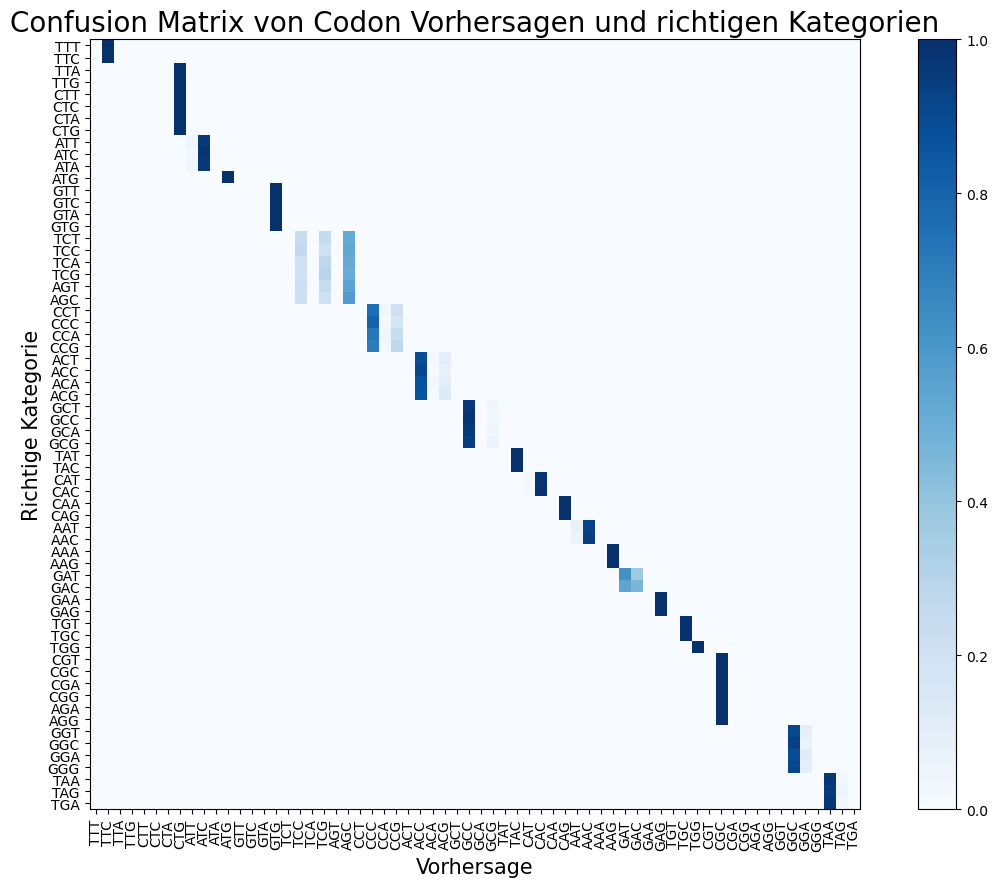

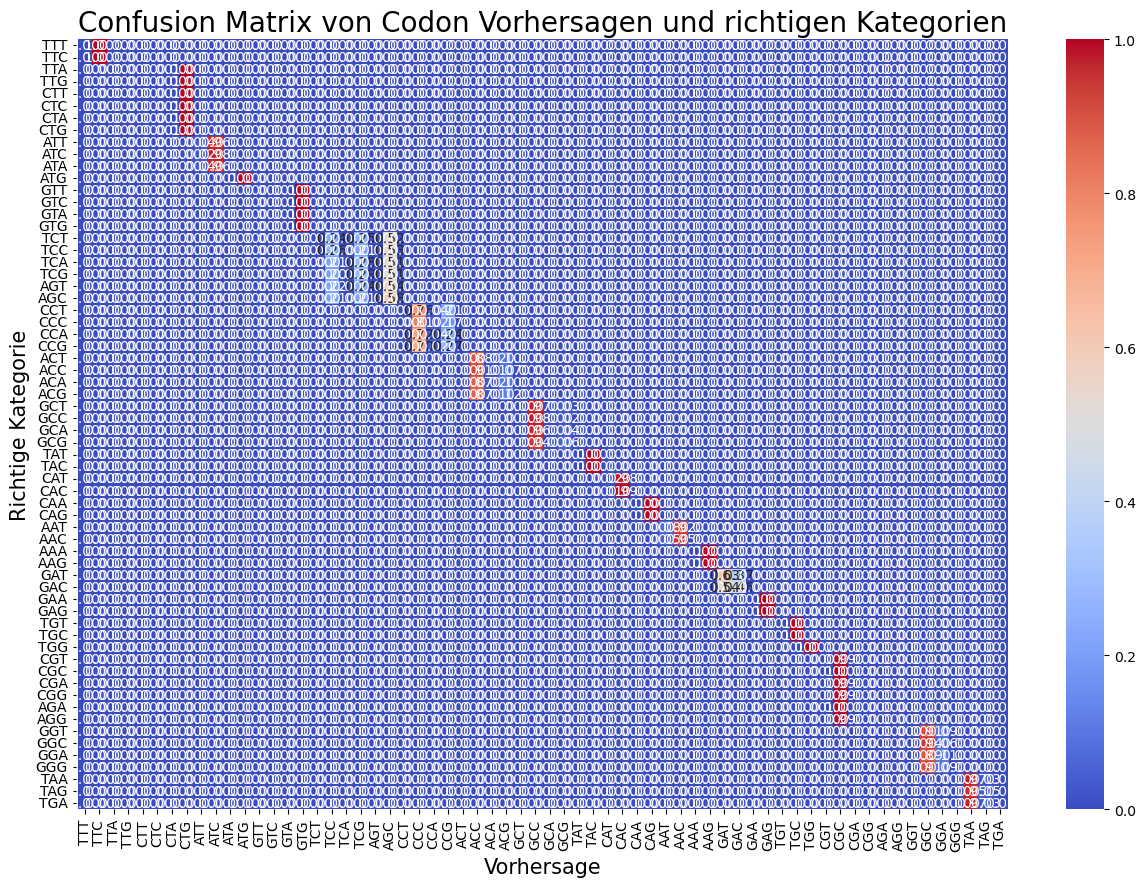

In [87]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien'

codons = [c for c in mlh.codons if c != '___']

plt = ml_evaluation.plot_confusion_matrix(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()
plt = ml_evaluation.plot_confusion_matrix_sns(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()

### Aminosäuren Accuracy

$$A\_Acc = \frac{T\_a}{G\_a} $$

- $T\_a$: Anzahl der richtig klassifizierten ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus
- $G\_a$: Gesamtanzahl der ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus

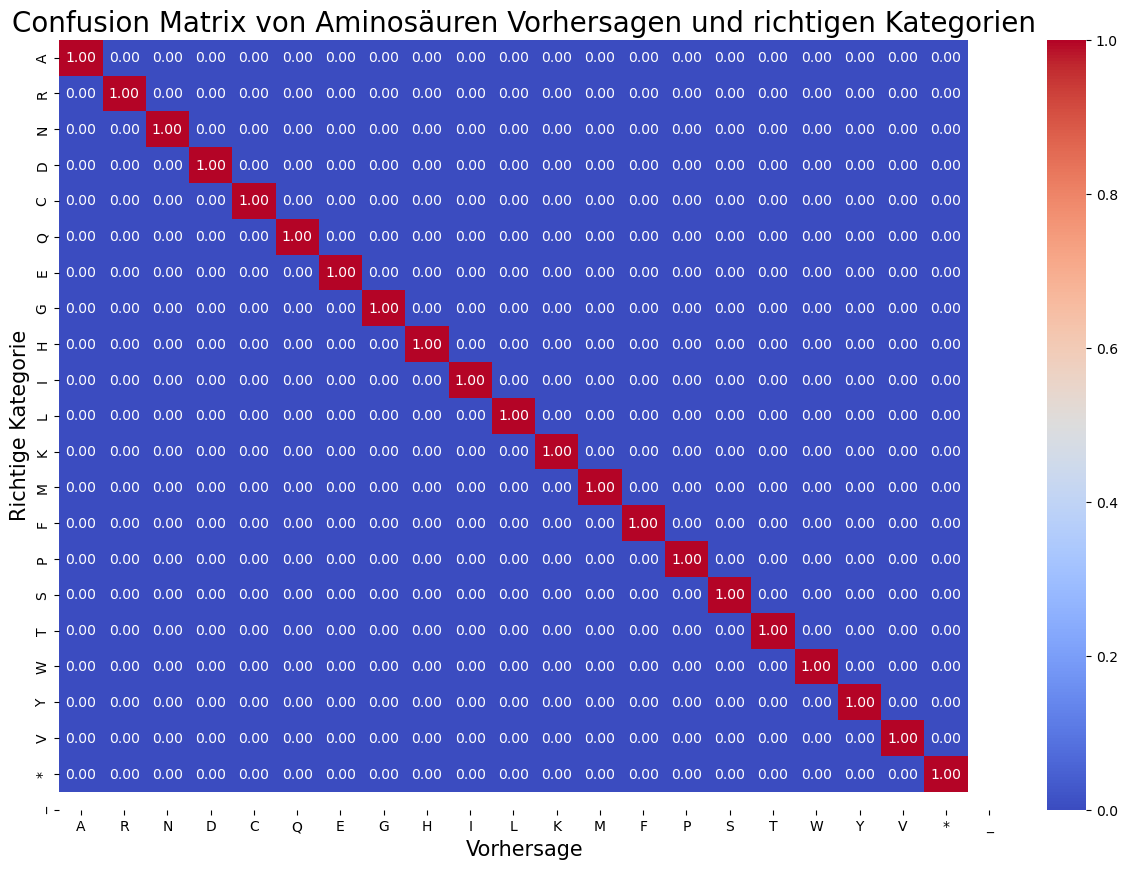

In [88]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, mlh.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien')
plt.show()

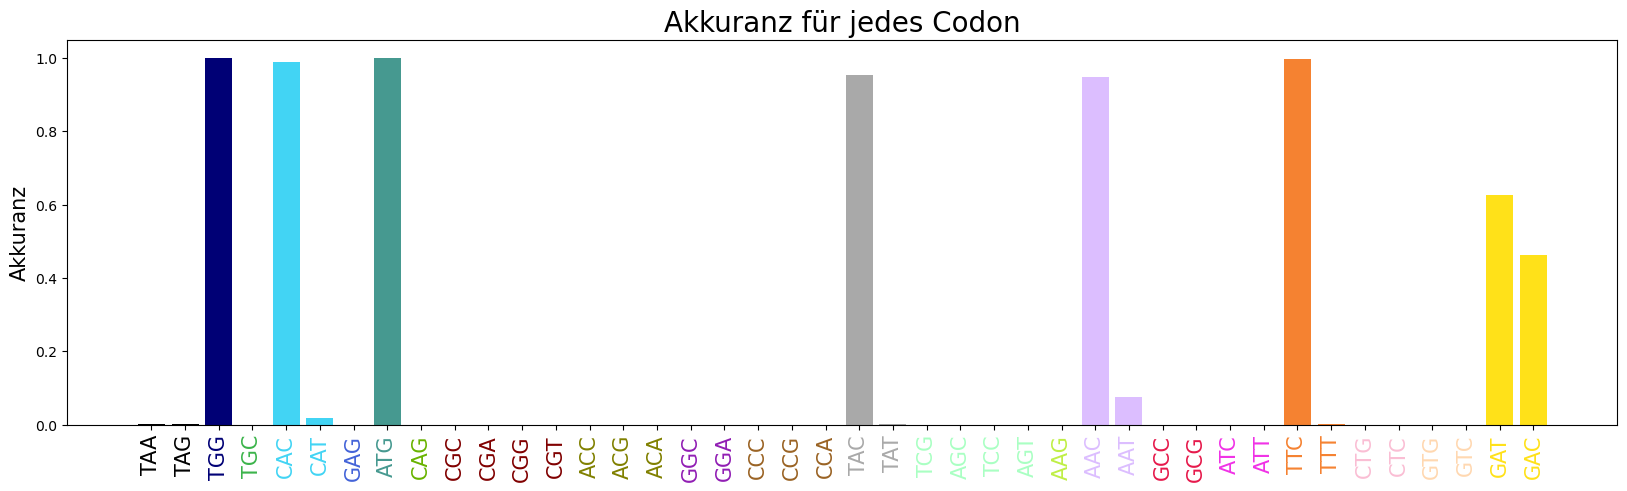

In [89]:
plt = ml_evaluation.plot_codon_acc(labels, predicted, 'Akkuranz für jedes Codon')

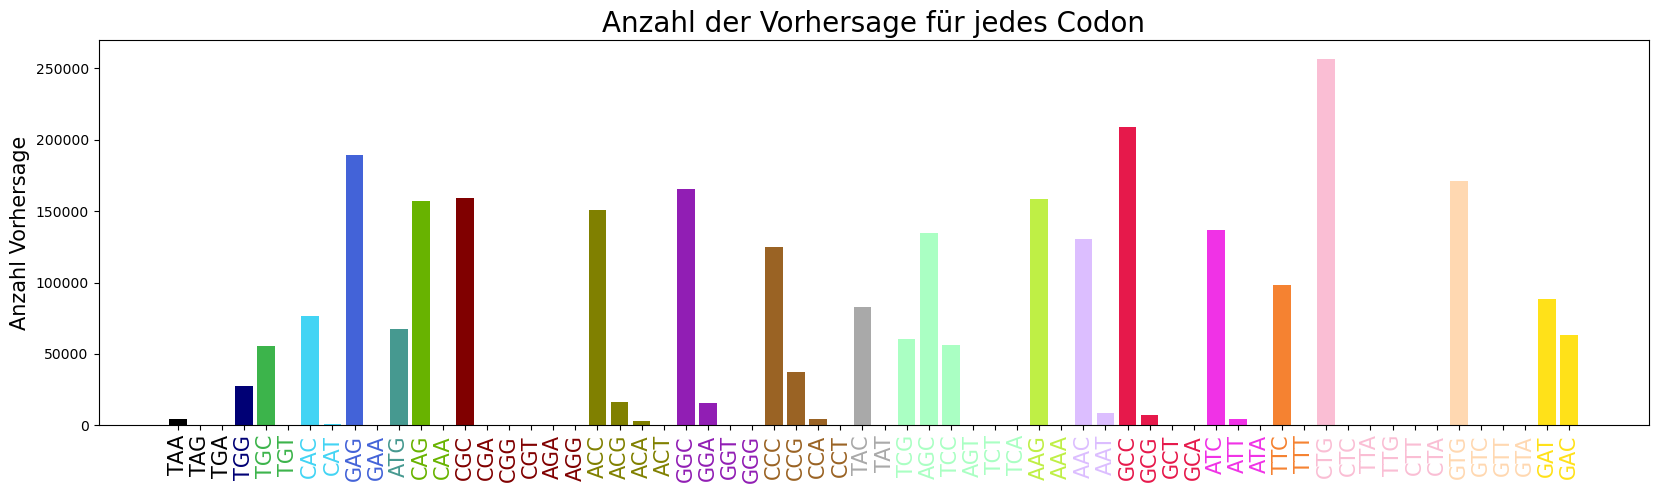

In [90]:
codon_counted_predicted = ml_evaluation.codon_count(predicted)

plt = ml_evaluation.plot_codon_count(codon_counted_predicted, 'Anzahl der Vorhersage für jedes Codon')

### Durchschnittliche Codon Accuracy

$$Avg\_CACC = \frac{\sum_{sc \in SC} c\_acc\{sc\}}{|SC|} $$

- $c\_acc$: Codon Accuracy
- $SC$: Synonyme Codons für die ausgewählte Aminosäure über alle Testsequenzen eines betrachteten Organismus

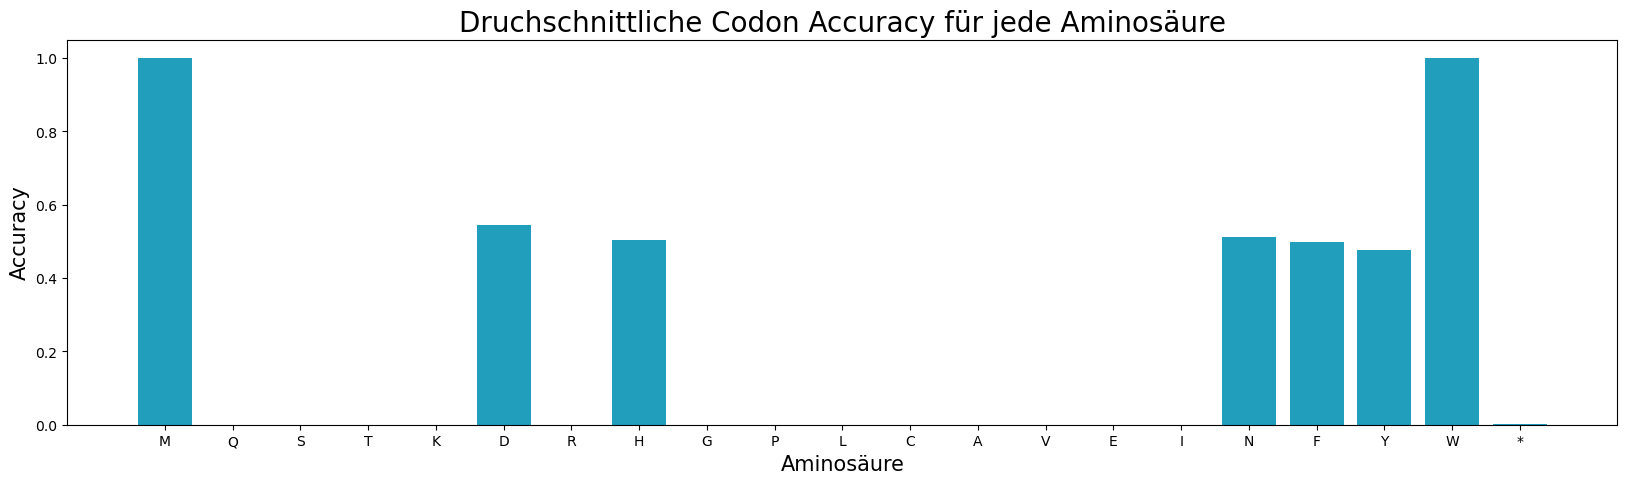

In [91]:
ml_evaluation.plot_avg_aa_acc(labels, predicted).show()

### Vergleich mit MCU

In [92]:
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
